<a href="https://colab.research.google.com/github/DenizY98/pydemo/blob/main/Fallstudie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prozessoptimierung - Fallstudie

##PIP, OR-Tools und Pandas

In [72]:
# Importieren der benötigten Bibliotheken
!pip install -U -q pip
!pip install -q ortools
# Laden des Programms
from ortools.linear_solver import pywraplp
import pandas as pd
# Initialisieren des Solvers
solver = pywraplp.Solver.CreateSolver('SCIP')

In [73]:
! git clone https://github.com/AlexKressner/Industrielles_Management

fatal: destination path 'Industrielles_Management' already exists and is not an empty directory.


In [74]:
path = "Industrielles_Management/Daten/Fallstudie/"

In [75]:
#dataframes laden aus Daten der CSV-Dateien
nachfrage_df = pd.read_csv(f"{path}/FLINK_Nachfrage.csv", sep=";", index_col=0) # Da Indizes in Datenquelle so festgelegt
standorte_df = pd.read_csv(f"{path}/FLINK_Standorte.csv", sep=";")

##Ziel:
Maximierung der bedienten Nachfrage innerhalb der vorgegebenen Lieferzeit und des Budgets.


##Daten:


###Indexmengen:
$ Q = \{q \mid q = (i,j), i \in \{0, \ldots, 12\}, j \in \{0, \ldots, 12\}\} $
Menge aller Quadranten $ q $ als $( i , j )$ Tupel


$ S = \{s \mid s \in \{0, \ldots, 9\}\} $
Menge aller potentieller DarkStores $ s $

In [76]:
Q = [(i, j) for i in range(nachfrage_df.shape[0]) for j in range(nachfrage_df.shape[1])]  # Menge aller Quadranten als (i, j) Paare
S = standorte_df['Potenzielle_Standorte'].to_list()  # Menge aller potentieller DarkStores

###Variablen:
$ x_s \in \{0,1\} \quad \forall s \in S $: Binärvariable, die angibt, ob am Standort $ s $ ein Dark Store eingerichtet wird $1$ oder nicht $0$.

$ y_{qs} \in \{0,1\} \quad \forall q \in Q, \forall s \in S $: Binärvariable, die angibt, ob der Standort $ s $ den Quadranten $ q (i,j) $ bedient $1$ oder nicht $0$.

In [77]:
x = {}
for s in S:
  x[s] = solver.BoolVar(f'x[{s}]')

In [78]:
y = {}
for s in S:
    for q in Q:
        y[q, s] = solver.BoolVar(f'y[{q},{s}]')

In [ ]:
z = {}
for s in S:
    for q in Q:

###Dictionaries:
- Lagerumschlagsleistung je potentiellem Standort $ s $
- Errichtungskosten je potentiellem Standort $ s $
- Koordinaten je potentiellem Standort $ s $

In [120]:
#Standorte Dataframe
Lagerumschlagleistung = standorte_df.set_index('Potenzielle_Standorte')['Lagerumschlagleistung'].to_dict()
Errichtungskosten = standorte_df.set_index('Potenzielle_Standorte')['Errichtungskosten'].to_dict()
Koordinaten = standorte_df.set_index('Potenzielle_Standorte')[['i_Koordinate','j_Koordinate']].to_dict('index')

In [121]:
Koordinaten

{0: {'i_Koordinate': 1, 'j_Koordinate': 0},
 1: {'i_Koordinate': 8, 'j_Koordinate': 11},
 2: {'i_Koordinate': 10, 'j_Koordinate': 4},
 3: {'i_Koordinate': 10, 'j_Koordinate': 10},
 4: {'i_Koordinate': 13, 'j_Koordinate': 6},
 5: {'i_Koordinate': 4, 'j_Koordinate': 8},
 6: {'i_Koordinate': 13, 'j_Koordinate': 7},
 7: {'i_Koordinate': 4, 'j_Koordinate': 6},
 8: {'i_Koordinate': 12, 'j_Koordinate': 6},
 9: {'i_Koordinate': 4, 'j_Koordinate': 4}}

###Parameter:

$ D_q $: Nachfrage im Quadranten $ q $ als Bestellungen pro Tag.

$ L_s $: Lagerumschlagleistung des Standorts $ s $ als Bestellungen pro Tag.

$ C_s $: Kosten für die Einrichtung eines Dark Stores am Standort $ s $.

$ B $: Gesamtbudget für die Einrichtung von Dark Stores.

$ T $: Maximale Lieferzeit $10 Minuten$.

$ A $: Maximale Anzahl von Quadranten, die ein Fahrradkurier bedienen kann $5 Quadranten$.


In [122]:
D = {q: nachfrage_df.iat[q[0],q[1]] for q in Q} # Nachfrage im Quadranten q als Bestellungen pro Tag
L = {s: Lagerumschlagleistung[s] for s in S}  # Lagerumschlagleistung des Standorts s als Bestellungen pro Tag
C = {s: Errichtungskosten[s] for s in S}  # Kosten für die Einrichtung eines Dark Stores am Standort s
B = 1000000  # Gesamtbudget für die Einrichtung von Dark Stores
T = 10  # Maximale Lieferzeit 10 Minuten
G = 25  # Geschwindigkeit in KM/H
K = 0.06666666 # 0.06666 Kästchen/1KM   ;Mulitplikations-Faktor für Kästchen A
A = round((T-4)/2*K*G, None)

###Restriktionen:
####Nachfragerestriktionen: $
\sum_{s \in S} y_{qs} \leq 1 \quad \forall q \in Q $
Jeder Quadrant wird von höchstens einem Dark Store bedient
####Budgetrestriktion: $
\sum_{s \in S} x_s \cdot C_s \leq B $
Ein Dark Store kann nur eingerichtet werden, wenn das Budget dies zulässt
####Lagerumschlagleistungsrestriktionen: $
\sum_{q \in Q} y_{qs} \cdot D_{q} \leq x_s \cdot L_s \quad \forall s \in S $
Die Nachfrage eines Quadranten kann nur bedient werden, wenn die Lagerumschlagleistung ausreicht und ein Dark Store vorhanden ist
####Reichweitenrestriktion für Fahrradkuriere: $
\text{Strecke}(s, q) > 5 \Rightarrow y_{qs} = 0 \quad \forall q \in Q, \forall s \in S $
Die Anzahl der von einem Fahrradkurier zurückgelegten Quadranten $Strecke$ darf nie größer $A$ sein, falls bestätigt, dass Quadrant $q$ von Standort $s$ beliefert wird.
<!--
####Liefergebietsrestriktionen: $
\sum_{q \in Q} y_{qs} \leq S_{\text{max}} \cdot x_s \quad \forall s \in S
$
Die Anzahl der von einem Dark Store bedienten Quadranten ist auf $ S_{\text{max}} $ beschränkt -->

$\text{Strecke}(s, q) > 5 \Rightarrow y_{qs} = 0 \quad \forall q \in Q, \forall s \in S $


In [123]:
# Nachfragerestriktionen
for q in Q:
    solver.Add(solver.Sum([y[q, s] for s in S]) <= 1)

# Budgetrestriktion
solver.Add(solver.Sum([x[s] * C[s] for s in S]) <= B)


# Lagerumschlagleistungsrestriktionen
for s in S:
    for q in Q:
        # Stellen Sie sicher, dass die Nachfrage, die von einem Darkstore bedient wird, seine Lagerumschlagleistung nicht übersteigt
        solver.Add(y[q, s] * D[q] / solver.Sum([y[q, s_prime] for s_prime in S if y[q, s_prime].solution_value() > 0]) <= x[s] * L[s])

# Lagerumschlagleistungsrestriktionen
# for s in S:
#     solver.Add(solver.Sum([y[q, s] * D[q] for q in Q]) <= x[s] * L[s])
# for s in S:
#         # Stellen Sie sicher, dass die Nachfrage, die von einem Darkstore bedient wird, seine Lagerumschlagleistung nicht übersteigt
#         solver.Add(y[q,s] * D[q]/solver.Sum([y[q, s] for q in Q]) <= x[s] * L[s])
#         solver.Add(y[q, s] * D[q] / solver.Sum([y[q, t] for t in S if y[q, t].solution_value() > 0]) <= x[s] * L[s])
# Reichweitenrestriktion für Fahrradkuriere
for s in S:
    for q in Q:
        # Berechnung der Manhattan-Distanz zwischen dem Standort s und dem Quadranten q
        distance = abs(Koordinaten[s]['i_Koordinate'] - q[0]) + abs(Koordinaten[s]['j_Koordinate'] - q[1])
        if distance > 5:
            solver.Add(y[q, s] == 0)


TypeError: unsupported operand type(s) for /: 'float' and 'SumArray'

##Lösung:
###Zielfunktion:
Maximiere die gesamte bediente Nachfrage:

$ \text{Max} \sum_{sq} y_{qs} \cdot D_q $

In [115]:
# Zielfunktion
solver.Maximize(solver.Sum([y[q, s] * D[q] for q in Q for s in S]))
# Lösen des Modells
status = solver.Solve()

In [116]:
# Ausgabe der Lösung
if status == pywraplp.Solver.OPTIMAL:
    print('Lösung gefunden:')
    for s in S:
        if x[s].solution_value() == 1:
            print(f'Standort {s} wird eingerichtet.')
            for q in Q:
                if y[q, s].solution_value() == 1:
                    print(f'Quadrant {q} wird von Standort {s} bedient.')
else:
    print('Keine optimale Lösung gefunden.')

Lösung gefunden:
Standort 1 wird eingerichtet.
Quadrant (3, 11) wird von Standort 1 bedient.
Quadrant (5, 11) wird von Standort 1 bedient.
Quadrant (6, 12) wird von Standort 1 bedient.
Quadrant (7, 10) wird von Standort 1 bedient.
Quadrant (8, 8) wird von Standort 1 bedient.
Quadrant (8, 10) wird von Standort 1 bedient.
Quadrant (9, 7) wird von Standort 1 bedient.
Quadrant (9, 11) wird von Standort 1 bedient.
Quadrant (10, 9) wird von Standort 1 bedient.
Quadrant (10, 10) wird von Standort 1 bedient.
Quadrant (10, 12) wird von Standort 1 bedient.
Quadrant (12, 12) wird von Standort 1 bedient.
Standort 2 wird eingerichtet.
Quadrant (8, 1) wird von Standort 2 bedient.
Quadrant (9, 0) wird von Standort 2 bedient.
Quadrant (9, 1) wird von Standort 2 bedient.
Quadrant (9, 2) wird von Standort 2 bedient.
Quadrant (9, 3) wird von Standort 2 bedient.
Quadrant (10, 0) wird von Standort 2 bedient.
Quadrant (10, 1) wird von Standort 2 bedient.
Quadrant (10, 2) wird von Standort 2 bedient.
Quadran

### Darstellung als Matrix, DF oder MatPlot

In [117]:
import numpy as np
# Erstellen Sie eine leere Matrix der gleichen Größe wie Ihr Quadrantengitter
ergebnis_matrix = np.empty((14, 14), dtype=object)  # Größe angepasst, um Store i_Koordinate von 13 zu berücksichtigen

# Füllen Sie die Matrix mit den Ergebnissen Ihres Modells
for s in S:
    if x[s].solution_value() == 1:
        # Wenn ein Darkstore an diesem Standort errichtet wurde, markieren Sie die Zelle mit "DS"
        for q in Q:
            # Überprüfen Sie, ob der Quadrant von diesem Standort bedient wird
            if y[q, s].solution_value() == 1:
                # Wenn ja, fügen Sie die Nummer des beliefernden Darkstores hinzu
                ergebnis_matrix[q[0], q[1]] = str(s)

# Nachdem alle Quadranten bedient wurden, gehen Sie erneut über alle Standorte in S
for s in S:
    if x[s].solution_value() == 1:
        # Wenn ein Darkstore an diesem Standort errichtet wurde, markieren Sie die Zelle mit "DS"
        i, j = Koordinaten[s]['i_Koordinate'], Koordinaten[s]['j_Koordinate']
        if 0 <= i < 14 and 0 <= j < 14:  # Stellen Sie sicher, dass die Koordinaten innerhalb der Matrix liegen
            ergebnis_matrix[i, j] = "S" + str(s)

# Ausgabe der Ergebnismatrix
ergebnis_df = pd.DataFrame(ergebnis_matrix)
ergebnis_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,None,None,None,9,9,7,7,7,5,5,None,None,None,None
1,None,None,9,9,7,7,7,7,7,5,5,None,None,None
2,None,9,9,7,7,7,7,7,7,7,5,None,None,None
3,9,9,9,7,7,7,7,7,7,7,7,1,5,None
4,9,7,9,7,S9,7,S7,7,S5,9,7,7,5,None
5,9,9,7,7,7,7,9,7,7,7,7,1,5,None
6,None,9,9,7,7,7,7,7,7,7,5,5,1,None
7,None,None,9,9,7,7,7,7,7,5,1,3,3,None
8,None,2,None,9,9,7,7,7,1,5,1,S1,3,None
9,2,2,2,2,9,4,7,1,5,3,3,1,3,None


####Visualisierung

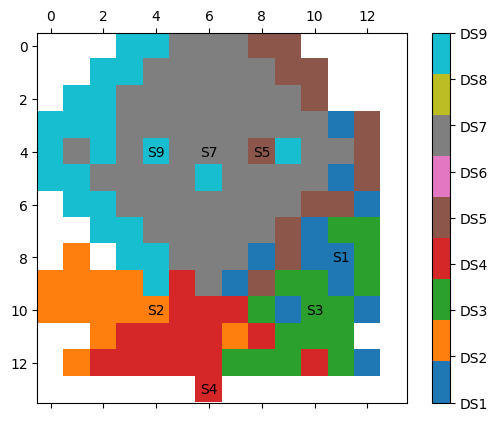

In [118]:
import matplotlib.pyplot as plt

# Erstellen Sie eine Kopie der Ergebnismatrix, in der die Darkstores und Quadranten durch eindeutige numerische Werte repräsentiert werden
num_matrix = ergebnis_matrix.copy()
for i in range(14):
    for j in range(14):
        if num_matrix[i, j] is not None:
            if "S" in num_matrix[i, j]:
                num_matrix[i, j] = int(num_matrix[i, j].replace("S", ""))
            else:
                num_matrix[i, j] = int(num_matrix[i, j])

# Ersetzen Sie None-Werte durch einen speziellen numerischen Wert
num_matrix[num_matrix == None] = -1

# Konvertieren Sie die Matrix in eine Matrix von Gleitkommazahlen
num_matrix = num_matrix.astype(float)

# Ersetzen Sie den speziellen numerischen Wert durch NaN
num_matrix[num_matrix == -1] = np.nan

# Erstellen Sie eine Farbkarte, die jedem Darkstore eine eindeutige Farbe zuweist
cmap = plt.get_cmap('tab10', int(np.nanmax(num_matrix) - np.nanmin(num_matrix) + 1))

# Erstellen Sie eine Abbildung und eine Achse
fig, ax = plt.subplots()

# Erstellen Sie die Matrix als Bild
cax = ax.matshow(num_matrix, cmap=cmap)

# Erstellen Sie eine Farblegende
cbar = fig.colorbar(cax, ticks=np.arange(np.nanmin(num_matrix), np.nanmax(num_matrix)+2))  # +2 statt +1
labels = ['DS'+str(i) for i in range(int(np.nanmin(num_matrix)), int(np.nanmax(num_matrix))+2)]  # Beginnen Sie bei DS0
cbar.ax.set_yticklabels(labels[:len(cbar.get_ticks())])  # Stellen Sie sicher, dass die Anzahl der Labels mit der Anzahl der Ticks übereinstimmt

# Zeichnen Sie ein 'X' in die Zellen, die einen Darkstore repräsentieren
for s in S:
    if x[s].solution_value() == 1:
        i, j = Koordinaten[s]['i_Koordinate'], Koordinaten[s]['j_Koordinate']
        if 0 <= i < 14 and 0 <= j < 14:  # Stellen Sie sicher, dass die Koordinaten innerhalb der Matrix liegen
            plt.text(j, i, f'S{str(s)}', ha='center', va='center', color='black')

# Zeigen Sie das Bild an
plt.show()